In [16]:
#Loading Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
from PIL import Image
import io

In [17]:
#Using Lossy and saving in JPEG format
def compress_image_jpeg(image_path, quality=20):
    image = Image.open(image_path)
    compressed_path = "compressed_image.jpg"
    image.save(compressed_path, "JPEG", quality=quality)
    return compressed_path

In [18]:
compress_image_jpeg("/content/7fda8d55bb873716812731909a2236e2 (1).jpg")

'compressed_image.jpg'

In [19]:
#Using Lossy and saving in PNG format
def compress_image_png(image_path):
    image = Image.open(image_path)
    compressed_path = "compressed_image.png"
    image.save(compressed_path, "PNG")
    return compressed_path

In [20]:
compress_image_png("/content/7fda8d55bb873716812731909a2236e2 (1).jpg")

'compressed_image.png'

In [21]:
#Creating CNN Model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [22]:
def evaluate_model(model, X_test, y_test, class_names):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate metrics
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    # ROC curve and AUC (one-vs-rest)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve((y_test[:, i]), y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }


In [23]:
def train_and_evaluate(dataset_name='mnist', epochs=10):
    # Load and preprocess data
    if dataset_name == 'mnist':
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)
        input_shape = (28, 28, 1)
        class_names = list(range(10))
    else:
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        input_shape = (32, 32, 3)
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']

    # Normalize pixel values
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255

    # Convert labels to categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Create and compile model
    model = create_cnn_model(input_shape, len(class_names))
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_split=0.2)

    # Evaluate model
    metrics = evaluate_model(model, X_test, y_test, class_names)

    return model, history, metrics


In [24]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

In [25]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [26]:
def plot_roc_curves(fpr, tpr, roc_auc, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i],
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8502 - loss: 0.4808 - val_accuracy: 0.9803 - val_loss: 0.0642
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9806 - loss: 0.0598 - val_accuracy: 0.9859 - val_loss: 0.0485
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9873 - loss: 0.0404 - val_accuracy: 0.9869 - val_loss: 0.0445
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9907 - loss: 0.0294 - val_accuracy: 0.9874 - val_loss: 0.0375
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9930 - loss: 0.0226 - val_accuracy: 0.9881 - val_loss: 0.0425
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9938 - loss: 0.0177 - val_accuracy: 0.9895 - val_loss: 0.0354
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9960 - loss: 0.0133 - val_accuracy: 0.9877 - val_loss: 0.0419
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9959 - loss: 0.0127 - val_accuracy: 0.

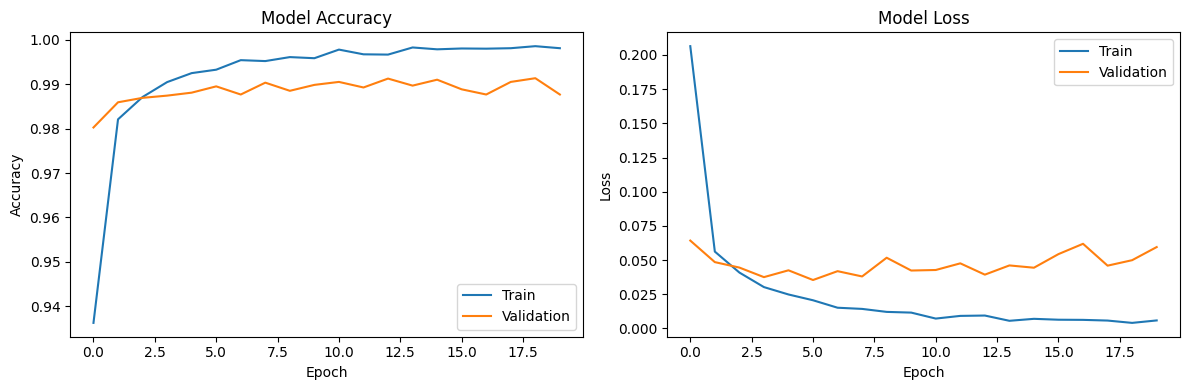

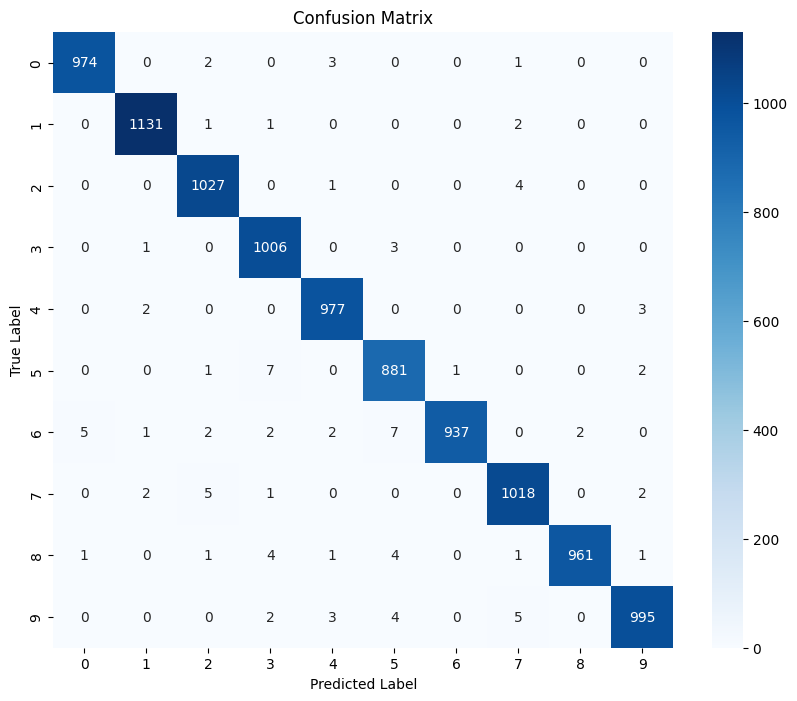

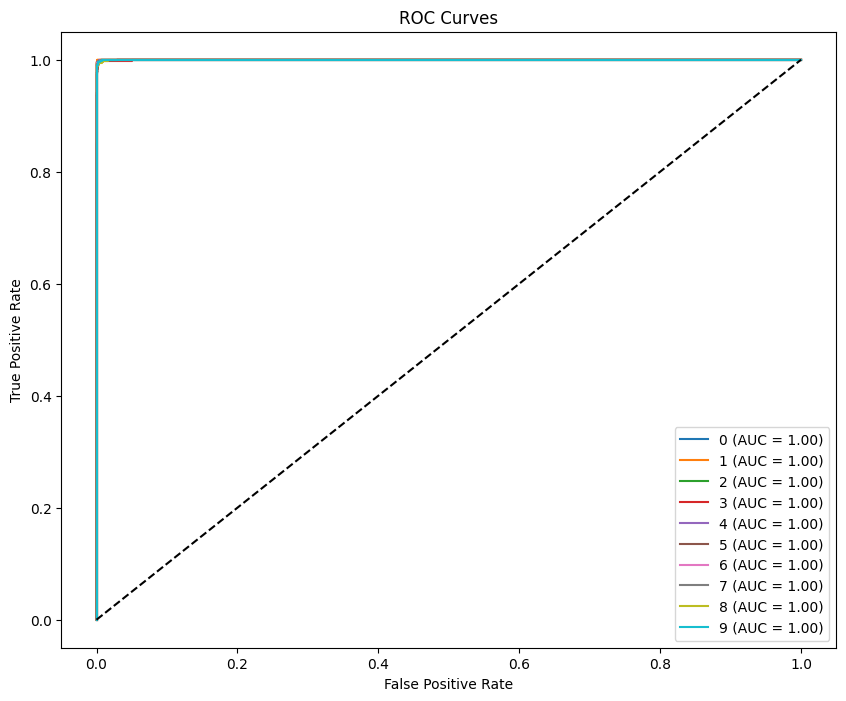

Precision: 0.9907
Recall: 0.9907
F1 Score: 0.9907


In [28]:
# Train on MNIST
mnist_model, mnist_history, mnist_metrics = train_and_evaluate('mnist', epochs=20)

# Plot results
plot_training_history(mnist_history)
plot_confusion_matrix(mnist_metrics['confusion_matrix'], list(range(10)))
plot_roc_curves(mnist_metrics['fpr'], mnist_metrics['tpr'], mnist_metrics['roc_auc'], list(range(10)))

# Print metrics
print(f"Precision: {mnist_metrics['precision']:.4f}")
print(f"Recall: {mnist_metrics['recall']:.4f}")
print(f"F1 Score: {mnist_metrics['f1']:.4f}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2935 - loss: 1.8779 - val_accuracy: 0.4736 - val_loss: 1.4328
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5151 - loss: 1.3422 - val_accuracy: 0.5586 - val_loss: 1.2450
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5804 - loss: 1.1832 - val_accuracy: 0.6064 - val_loss: 1.1161
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6243 - loss: 1.0570 - val_accuracy: 0.6372 - val_loss: 1.0431
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6573 - loss: 0.9680 - val_accuracy: 0.6561 - val_loss: 0.9862
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6819 - loss: 0.8976 - val_accuracy: 0.6708 - val_loss: 0.9471
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7046 - loss: 0.8438 - val_accuracy: 0.6779 - val_loss: 0.9270
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7224 - loss: 0.7937 - val_accuracy: 0.

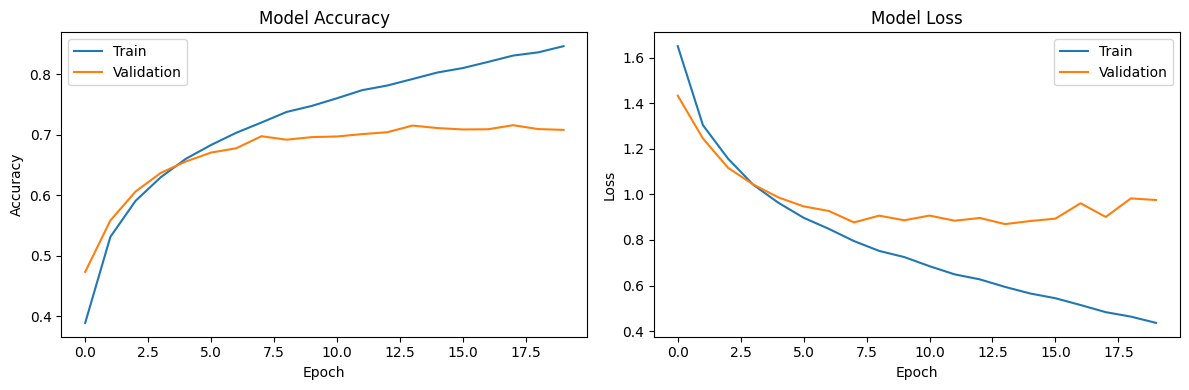

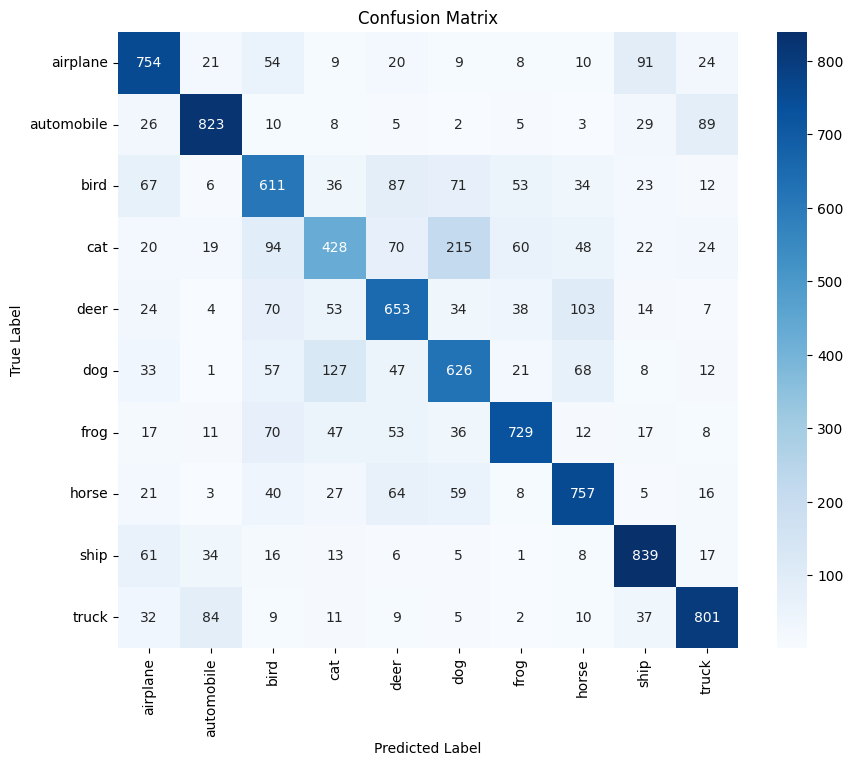

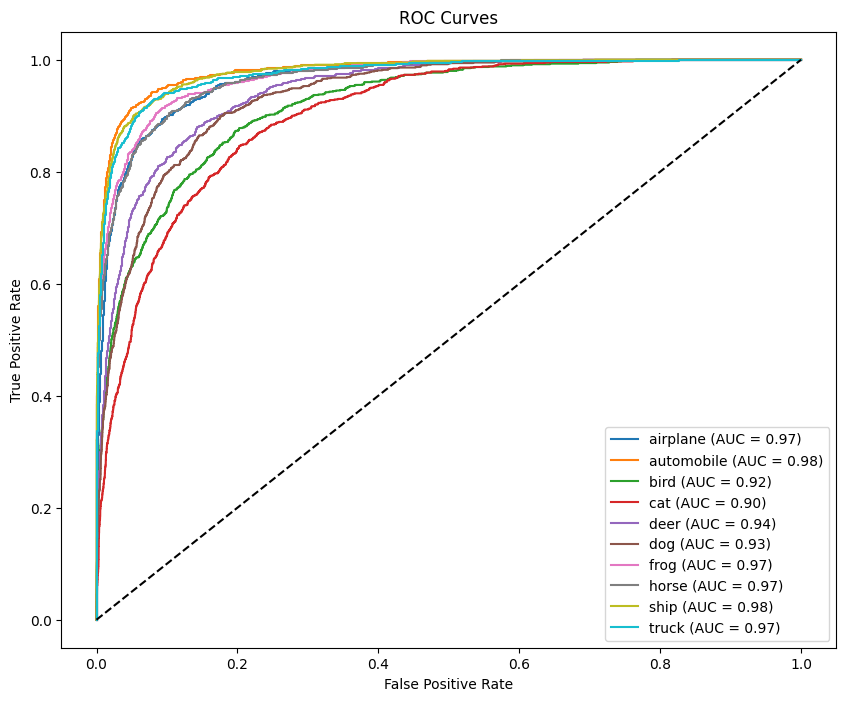

Precision: 0.6996
Recall: 0.7021
F1 Score: 0.6995


In [29]:
# Train on CIFAR-10
cifar_model, cifar_history, cifar_metrics = train_and_evaluate('cifar10', epochs=20)

# Plot results
plot_training_history(cifar_history)
plot_confusion_matrix(cifar_metrics['confusion_matrix'],
                     ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck'])
plot_roc_curves(cifar_metrics['fpr'], cifar_metrics['tpr'], cifar_metrics['roc_auc'],
                ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck'])

# Print metrics
print(f"Precision: {cifar_metrics['precision']:.4f}")
print(f"Recall: {cifar_metrics['recall']:.4f}")
print(f"F1 Score: {cifar_metrics['f1']:.4f}")